<a href="https://colab.research.google.com/github/chaitragopalappa/MIE590-690D/blob/main/3a_Code_NN_Nuts_and_Bolts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Exercise - Experiment with the various nuts and bolts of NN

Use a toy data set (e.g., y=x^2 or y= sin(x)) to experiment below
* Activation functions
* Optimizers
* Hyperparameters (inputs to different optimizers, NN architecture)
* Regularization (early stop, weight decay, and drop-out)
You can use/expand on the code 2d_Code_Pytorch_basics.ipynb or write your own code.
Use vizuals where needed - e.g., plot input and outsignals from every node in hidden layers to unerstand role of activation fucntions.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from tensorboardX import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
#from tensorboardX import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

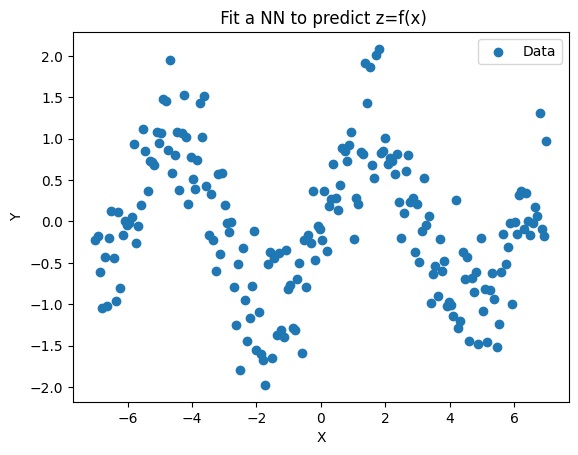

In [10]:
# @title Generate Synthetic Data  { vertical-output: true }

# ------------------ Generate Data ------------------ #
x = torch.linspace(-7, 7, 200).unsqueeze(1)   # [200,1]
#y = x**2 + torch.randn(200, 1) * 0.5
y = torch.sin(x) + torch.randn(200, 1) * 0.5
plt.scatter(x, y, label='Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title(' Fit a NN to predict z=f(x)')
plt.show()

# Observe the NN pipeline has been coded differently than in the first example
Instead of initializing a 'sequential' pipeline (as in 2d_Code), we can use forward to code the sequence for the forward pass, and initialize just the layers in def __init.

Epoch 0, Loss = 1.103840
Epoch 100, Loss = 0.558538
Epoch 200, Loss = 0.440434
Epoch 300, Loss = 0.495107
Epoch 400, Loss = 0.451209


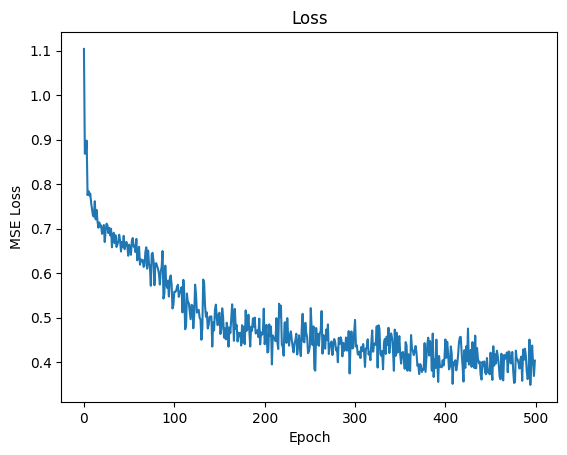

In [11]:

# ------------------ Define Model ------------------ #
class Net(nn.Module):
    def __init__(self, hidden_size=16, dropout_prob=0, activation="SELU"):
        super(Net, self).__init__()

        # choose activation function
        if activation.upper() == "SELU": #SELU is standardized ELU, which automatically does normalization similar to batchnorm - we will look at batchnorm at a later time.
            self.act = nn.SELU()
        elif activation.upper() == "RELU":
            self.act = nn.ReLU()
        elif activation.upper() == "TANH":
            self.act = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        self.fc1 = nn.Linear(1, hidden_size)
        self.drop1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.drop2 = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # ---- Layer 1 ----
        x = self.fc1(x)
        h1_in = x.clone().detach()
        x = self.act(x)
        h1_out = x.clone().detach()
        x = self.drop1(x)

        # ---- Layer 2 ----
        x = self.fc2(x)
        h2_in = x.clone().detach()
        x = self.act(x)
        h2_out = x.clone().detach()
        x = self.drop2(x)

        # ---- Output Layer ----
        x = self.fc3(x)

        # store signals for visualization
        self.hidden_signals = {
            "layer1_in": h1_in,
            "layer1_out": h1_out,
            "layer2_in": h2_in,
            "layer2_out": h2_out
        }
        return x


# ------------------ Instantiate Model ------------------ #
model = Net(hidden_size=16, dropout_prob=0.1, activation="SELU")

# loss + optimizer with weight decay
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

# ------------------ Training ------------------ #
epochs = 500
lossval = []

def iter_backprop():
    y_pred = model(x)
    loss = loss_function(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossval.append(loss.item())
    return (x, y, y_pred, loss, lossval)

for j in range(epochs):
    (x_train,y_train,y_pred,loss,lossval) = iter_backprop()
    if j % 100 == 0:
        print(f"Epoch {j}, Loss = {loss.item():.6f}")

# ------------------ Plot Loss ------------------ #
plt.plot(lossval)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()



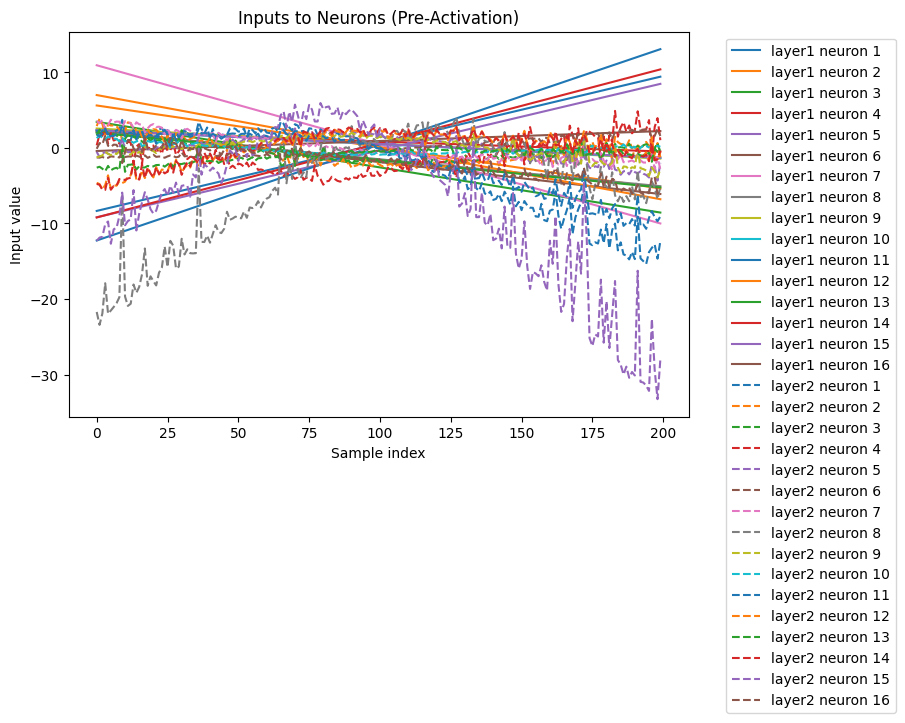

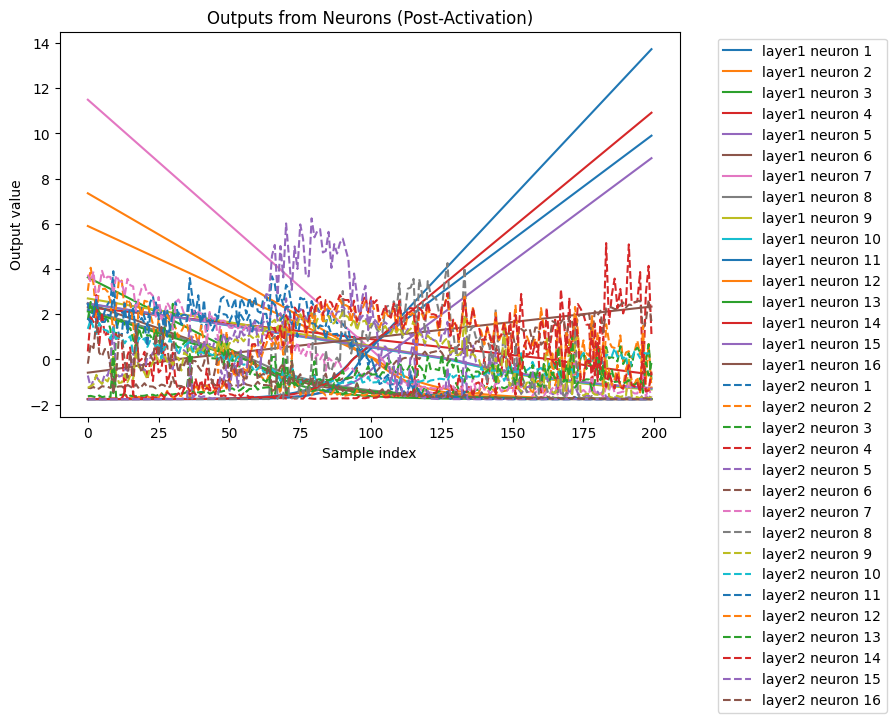

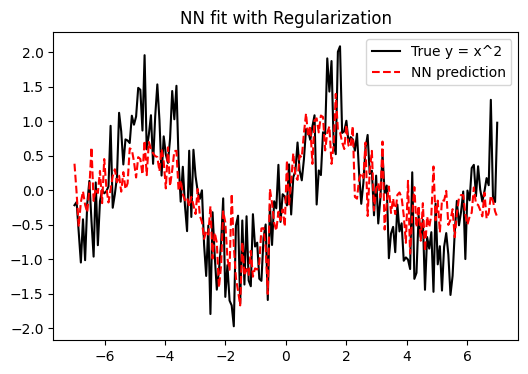

In [13]:

# ------------------ Signal Visualization ------------------ #
def plot_inputs_and_outputs(signals_dict):
    """
    Two plots:
    - All inputs (pre-activation) with layer1 solid, layer2 dashed
    - All outputs (post-activation) with layer1 solid, layer2 dashed
    """
    # -------- Inputs -------- #
    plt.figure(figsize=(8,5))
    for key, signals in signals_dict.items():
        if "in" in key:
            layer = key.split("_")[0]
            style = "-" if layer == "layer1" else "--"
            color_cycle = itertools.cycle(plt.cm.tab10.colors)
            for i in range(signals.shape[1]):
                plt.plot(signals[:, i].numpy(),
                         linestyle=style,
                         color=next(color_cycle),
                         label=f"{layer} neuron {i+1}")
    plt.title("Inputs to Neurons (Pre-Activation)")
    plt.xlabel("Sample index")
    plt.ylabel("Input value")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()

    # -------- Outputs -------- #
    plt.figure(figsize=(8,5))
    for key, signals in signals_dict.items():
        if "out" in key:
            layer = key.split("_")[0]
            style = "-" if layer == "layer1" else "--"
            color_cycle = itertools.cycle(plt.cm.tab10.colors)
            for i in range(signals.shape[1]):
                plt.plot(signals[:, i].numpy(),
                         linestyle=style,
                         color=next(color_cycle),
                         label=f"{layer} neuron {i+1}")
    plt.title("Outputs from Neurons (Post-Activation)")
    plt.xlabel("Sample index")
    plt.ylabel("Output value")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()

# forward once to log signals
_ = model(x)
plot_inputs_and_outputs(model.hidden_signals)

# ------------------ Final Fit Plot ------------------ #
plt.figure(figsize=(6,4))
plt.plot(x.numpy(), y.numpy(), label="True y = x^2", color="black")
plt.plot(x.numpy(), model(x).detach().numpy(), label="NN prediction", color="red", linestyle="--")
plt.legend()
plt.title("NN fit with Regularization")
plt.show()